# Modeling and Simulation in Python

Chapter 10: Vectors

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

### Vectors

A `Vector` object is like a combination of a NumPy array and a Pint Quantity.

I'll start by grabbing the units we'll need.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

Here's a two dimensional `Vector` in meters.

In [3]:
A = Vector(3, 4) * m

We can access the elements by name.

In [4]:
A.x

<Quantity(3.0, 'meter')>

In [5]:
A.y

<Quantity(4.0, 'meter')>

The magnitude is the length of the vector.

In [6]:
A.mag

<Quantity(5.0, 'meter')>

The angle is the number of radians between the vector and the positive x axis.

In [7]:
A.angle

<Quantity(0.9272952180016122, 'radian')>

If we make another `Vector` with the same units,

In [8]:
B = Vector(1, 2) * m

We can add `Vector` objects like this

In [9]:
A + B

<Quantity([ 4.  6.], 'meter')>

And substract like this:

In [10]:
A - B

<Quantity([ 2.  2.], 'meter')>

We can compute the Euclidean distance between two Vectors.

In [11]:
A.dist(B)

<Quantity(2.8284271247461903, 'meter')>

And the difference in angle

In [12]:
A.diff_angle(B)

<Quantity(-0.17985349979247822, 'radian')>

If we are given the magnitude and angle of a vector, what we have is the representation of the vector in polar coordinates.

In [13]:
mag = A.mag
angle = A.angle

We can use `pol2cart` to convert from polar to Cartesian coordinates, and then use the Cartesian coordinates to make a `Vector` object.

In this example, the `Vector` we get should have the same components as `A`.

In [14]:
x, y = pol2cart(angle, mag)
Vector(x, y)

<Quantity([ 3.  4.], 'meter')>

**Exercise:** Create a `Vector` named `a_grav` that represents acceleration due to gravity, with x component 0 and y component $-9.8$ meters / second$^2$.

In [15]:
a_grav=(0, -9.8)*m/(s**2)

In [16]:
# Solution goes here

### Degrees and radians

Pint provides units to represent degree and radians.

In [17]:
degree = UNITS.degree
radian = UNITS.radian

If you have an angle in degrees,

In [18]:
angle = 45 * degree
angle

<Quantity(45, 'degree')>

You can convert to radians.

In [19]:
angle_rad = angle.to(radian)
angle_rad

<Quantity(0.7853981633974483, 'radian')>

If it's already in radians, `to` does the right thing.

In [20]:
angle_rad.to(radian)

<Quantity(0.7853981633974483, 'radian')>

You can also convert from radians to degrees.

In [21]:
angle_rad.to(degree)

<Quantity(45.0, 'degree')>

As an alterative, you can use `np.deg2rad`, which works with Pint quantities, but it also works with simple numbers and NumPy arrays:

In [22]:
np.deg2rad(angle)

<Quantity(0.7853981633974483, 'radian')>

**Exercise:** Create a `Vector` named `a_force` that represents acceleration due to a force of 0.5 Newton applied to an object with mass 0.3 kilograms, in a direction 45 degrees up from the positive x-axis.

Add `a_force` to `a_drag` from the previous exercise.  If that addition succeeds, that means that the units are compatible.  Confirm that the total acceleration seems to make sense.

In [23]:
N = .5*UNITS.newton
m = .3*UNITS.kilogram
angle = 45*degree
x, y = pol2cart(angle.to(radian),1)
force = N/m
a_force = force*(x,y)




In [24]:
a_force

<Quantity([ 1.1785113  1.1785113], 'newton / kilogram')>

### Baseball

Here's a `Condition` object that contains the parameters for the Manny Ramirez problem.

In [25]:
condition = Condition(x = 0 * m, 
                      y = 1 * m,
                      g = 9.8 * m/s**2,
                      mass = 145e-3 * kg,
                      diameter = 73e-3 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.3,
                      angle = 40 * degree,
                      velocity = 40 * m / s,
                      duration = 5.1 * s)

And here's the function that uses the `Condition` object to make a `System` object.

In [26]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

Here's how we use it:

In [27]:
system = make_system(condition)
system

,value
init,x 0.0 kilogram y ...
g,2.94 kilogram / second ** 2
mass,0.145 kilogram
area,0.00037668481314705014 kilogram ** 2
rho,44.44444444444445 1 / kilogram ** 2
C_d,0.3
ts,"[0.0 second, 0.051 second, 0.102 second, 0.153..."


Here's the slope function that computes acceleration due to gravity and drag.

In [28]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

Always test the slope function with the initial conditions.

In [29]:
slope_func(system.init, 0, system)

(<Quantity(9.192533317427737, 'kilogram / second')>,
 <Quantity(7.713451316238471, 'kilogram / second')>,
 <Quantity(-1.910448383461131, 'kilogram / second ** 2')>,
 <Quantity(-4.543056533945466, 'kilogram / second ** 2')>)

Now we can run `odeint`

In [30]:
run_odeint(system, slope_func)

Here are the first few time steps.

In [31]:
system.results.head()

,x,y,vx,vy
0.000,0.000000,300.000000,9192.533317,7713.451316
0.051,466.358624,687.511228,9096.505321,7483.716367
0.102,927.890040,1063.403847,9003.212509,7257.791994
0.153,1384.730969,1427.868064,8912.547090,7035.517498
0.204,1837.012758,1781.086075,8824.406390,6816.740105


And the last few.  The last value of `y` is negative, indicating that the ball hit the ground before the end of the simulation.

In [32]:
system.results.tail()

,x,y,vx,vy
4.896,32247.749911,-1644.042361,4766.965376,-6751.863979
4.947,32489.977691,-1990.944593,4732.162283,-6851.960659
4.998,32730.430402,-2342.923510,4697.355519,-6950.949220
5.049,32969.107962,-2699.922536,4662.549167,-7048.827363
5.100,33206.010496,-3061.884991,4627.747426,-7145.593235


### Visualizing the results

We can extract the x and y components as `Series` objects.

In [33]:
xs = system.results.x
ys = system.results.y

xs

0.000        0.000000
0.051      466.358624
0.102      927.890040
0.153     1384.730969
0.204     1837.012758
0.255     2284.861665
0.306     2728.399051
0.357     3167.741622
0.408     3603.001636
0.459     4034.287088
0.510     4461.701900
0.561     4885.346084
0.612     5305.315913
0.663     5721.704069
0.714     6134.599758
0.765     6544.088867
0.816     6950.254093
0.867     7353.175043
0.918     7752.928357
0.969     8149.587800
1.020     8543.224366
1.071     8933.906365
1.122     9321.699515
1.173     9706.667015
1.224    10088.869631
1.275    10468.365760
1.326    10845.211505
1.377    11219.460733
1.428    11591.165136
1.479    11960.374303
             ...     
3.621    25618.602313
3.672    25904.770778
3.723    26189.201754
3.774    26471.894196
3.825    26752.846837
3.876    27032.058215
3.927    27309.526705
3.978    27585.250545
4.029    27859.227867
4.080    28131.456716
4.131    28401.935083
4.182    28670.660923
4.233    28937.632180
4.284    29202.846801
4.335    2

The simplest way to visualize the results is to plot x and y as functions of time.

<IPython.core.display.Javascript object>


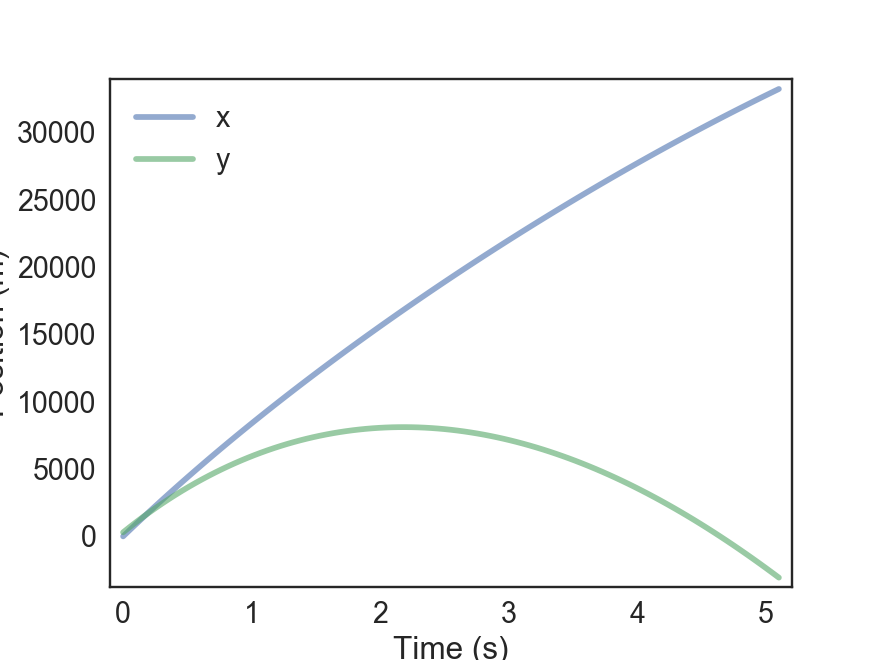

Saving figure to file chap10-fig01.pdf


In [34]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

savefig('chap10-fig01.pdf')

We can plot the velocities the same way.

In [42]:
vxs = system.results.vx
vys = system.results.vy

The x velocity slows down due to drag.  The y velocity drops quickly while drag and gravity are in the same direction, then more slowly after the ball starts to fall.

<IPython.core.display.Javascript object>


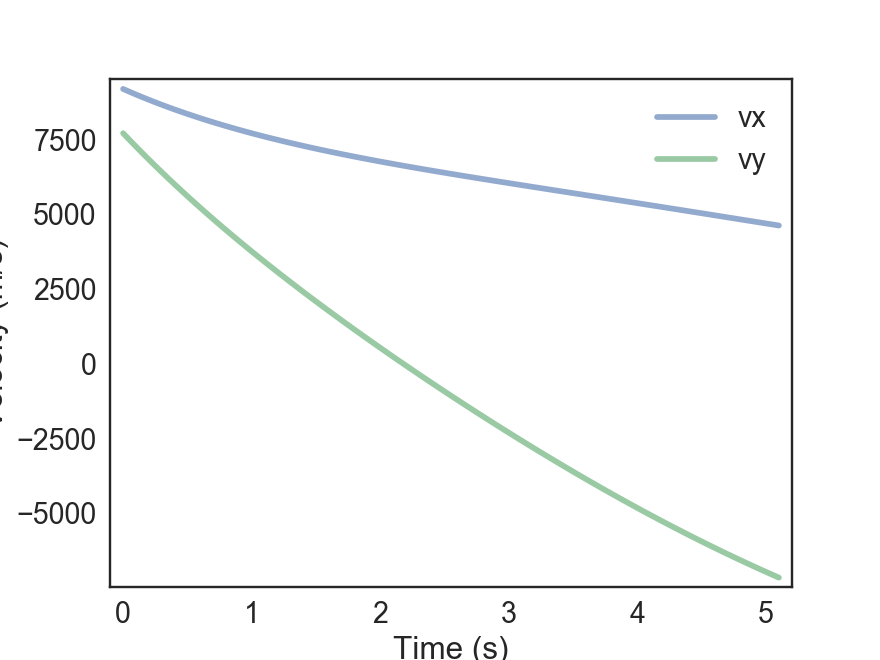

In [43]:
newfig()
plot(vxs, label='vx')
plot(vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory of the ball through its plane of motion.

<IPython.core.display.Javascript object>


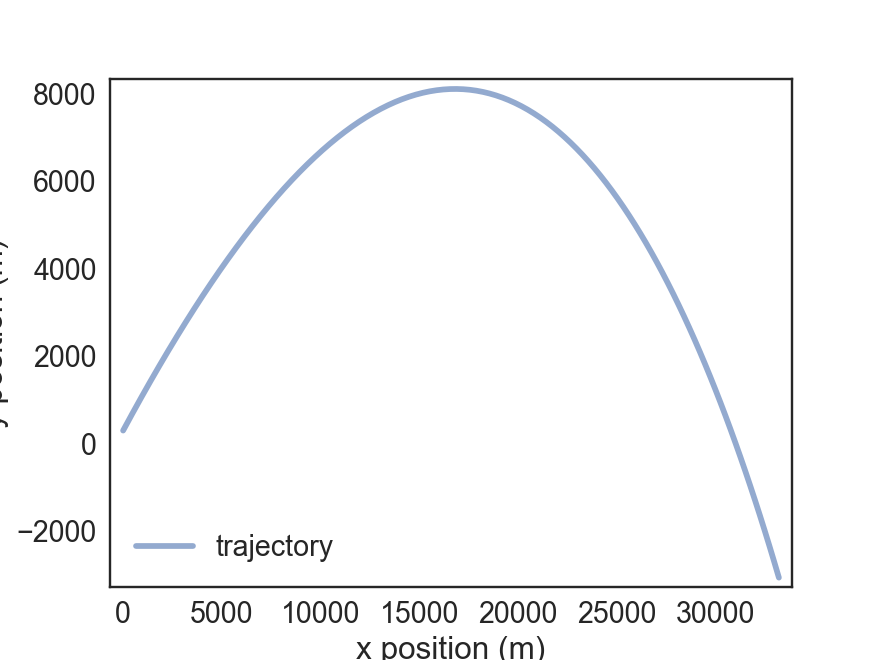

Saving figure to file chap10-fig02.pdf


In [44]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

savefig('chap10-fig02.pdf')

We can also animate the flight of the ball.  If there's an error in the simulation, we can sometimes spot it by looking at animations.

<IPython.core.display.Javascript object>


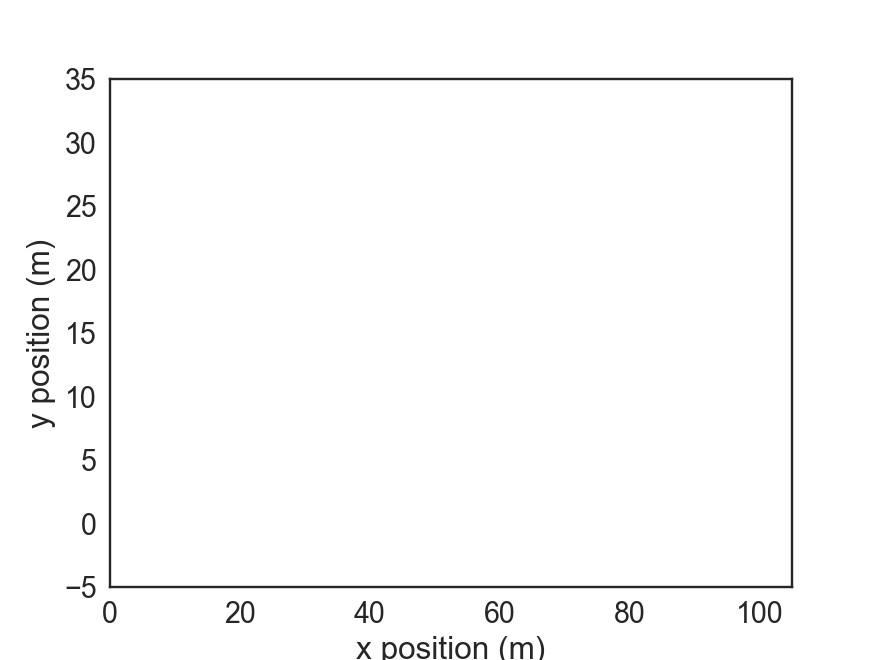

In [45]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 105],
         ylim=[-5, 35],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

Here's a function that encapsulates that code and runs the animation in (approximately) real time.

In [46]:
dts = np.append(np.diff(xs.index),0)
dts

array([ 0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,  0.051,
        0.051,  0.051,  0.051,  0.051,  0.   ])

In [47]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

<IPython.core.display.Javascript object>


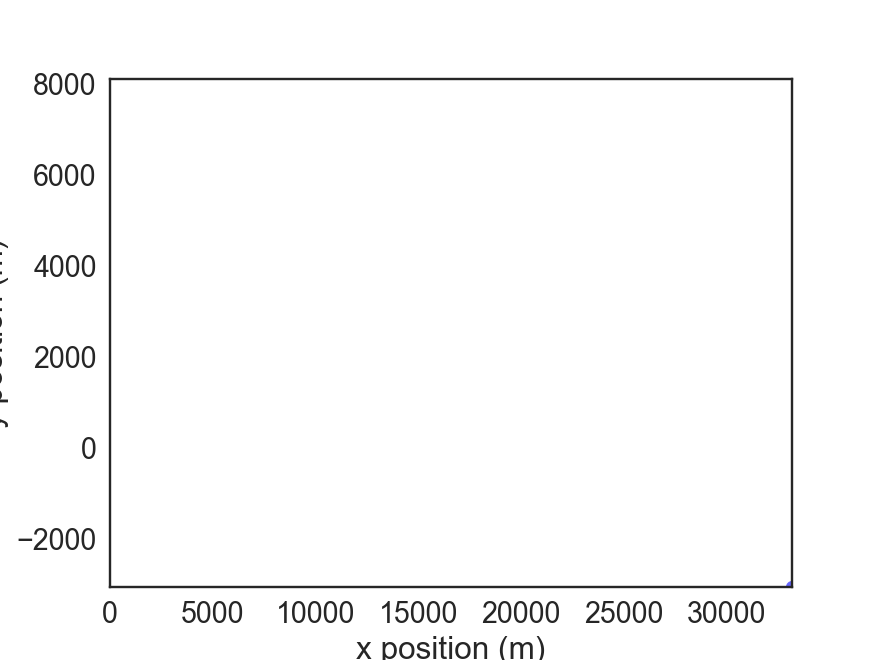

In [48]:
animate2d(system.results.x, system.results.y)

**Exercise:** Run the simulation for a few different launch angles and visualize the results.  Are they consistent with your expectations?

### Finding the range

Next we'll find the time and distance when the ball hits the ground.

In [49]:
condition.set(duration=7*s)
system = make_system(condition)
run_odeint(system, slope_func)

We have to interpolate y to find the landing time, then interpolate x to find the range.

In [50]:
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

Here's the result.

In [51]:
interpolate_range(system.results)

array(31019.78312567125)

**Exercise:** The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / meter$^3$.  How much farther would a ball hit with the same velocity and launch angle travel?

In [52]:
condition2 = Condition(condition)
condition2.set(rho = 1*kg/(m**3))

In [53]:
system = make_system(condition2)
run_odeint(system, slope_func)
interpolate_range(system.results)

array(32866.539049926454)

### Optimal launch angle

To find the launch angle that maximizes range, we need a function that takes launch angle and returns range.

In [54]:
def range_func(angle, condition):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: distance in meters
    """
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    x_range = interpolate_range(system.results)
    print(angle)
    return x_range

Let's test `range_func`.

In [55]:
%time range_func(45, condition)

45
Wall time: 400 ms


array(32721.63619101987)

And sweep through a range of angles.

In [56]:
angles = linspace(30, 60, 11)
sweep = SweepSeries()

for angle in angles:
    x_range = range_func(angle, condition)
    print(angle, x_range)
    sweep[angle] = x_range

30.0
30.0 30667.53843861518
33.0
33.0 31683.220215036617
36.0
36.0 32391.60144005214
39.0
39.0 32797.576943830216
42.0
42.0 32905.986486316826
45.0
45.0 32721.63619101987
48.0
48.0 32249.37342689747
51.0
51.0 31494.206129460763
54.0
54.0 30461.448852109173
57.0
57.0 29156.909377944547
60.0
60.0 27587.109056842066


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

<IPython.core.display.Javascript object>


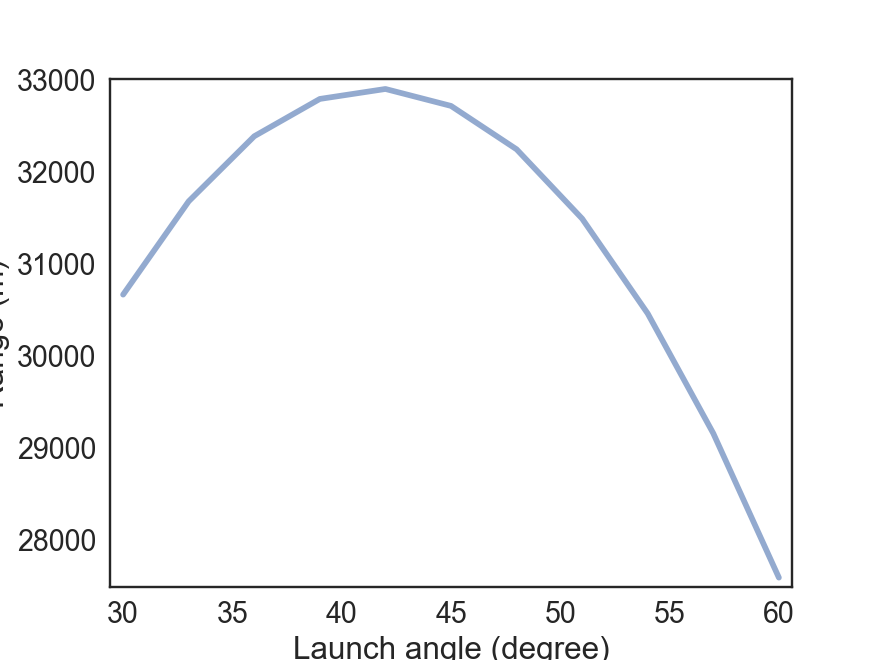

Saving figure to file chap10-fig03.pdf


In [57]:
newfig()
plot(sweep)
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         legend=False)

savefig('chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [58]:
%time res = max_bounded(range_func, [0, 90], condition)

45.0
34.3769410125
55.6230589875
21.246117975
41.8191038612
41.6971468804
41.6051022416
41.6031026437
41.6034365941
41.6027686933
Wall time: 4.12 s


The result is an `OptimizeResult` object.

In [59]:
type(res)

scipy.optimize.optimize.OptimizeResult

With the following variables.

In [60]:
res

     fun: 32908.552177847516
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 41.60310264372518

So the optimal angle is about 41 degrees, and the resulting range is 103 meters.

**Exercise:** Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

### Turning off units

Each time `range_func` runs, it calls `odeint`, which runs `slope_func` many times.  And each time `slop_func` runs, it checks the units for all computations, which takes some time.  We can speed up the whole process by removing the units from the computation (now that we are satisfied that they are correct).

Because of the way we organized the code, all units are in the `Condition` object, so we can "turn off units" by defining a new `Condition` object with no units:

In [61]:
condition = Condition(g = 9.8,
                      mass = 145e-3,
                      diameter = 73e-3,
                      rho = 1.2,
                      C_d = 0.3,
                      angle = 45,
                      velocity = 40,
                      duration = 7)

Now `range_func` and `max_bounded` are substantially faster.

In [62]:
%time range_func(45, condition)

ValueError: The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough.

In [63]:
%time res = max_bounded(range_func, [0, 90], condition)

Before running scipy.integrate.odeint, I tried
                 running the slope function you provided with the
                 initial conditions in system and t=0, and I got
                 the following error:


ValueError: The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough.

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it launches at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a condition as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [87]:
condition = Condition(g = 9.8,
                      mass = 145e-3,
                      diameter = 73e-3,
                      rho = 1.2,
                      C_d = 0.3,
                      angle = 45,
                      velocity = 40,
                      duration = 7)
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y
def height_func(angle, condition):

    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    
    time = interp_inverse(system.results.x)
    #creates a function that takes distance and returns a time
    top_wall_time = time(94.5)
    print(top_wall_time)
    
    height = interpolate(system.results.y)
    #creates function that takes time and returns height
    return height(top_wall_time)

Test your function with a launch angle of 45 degrees:

In [86]:
height_func(45, condition)

4.5239116773281545


array(310.025366583221)

Now use `max_bounded` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [88]:
opt = max_bounded(height_func, [0, 90], condition)

4.5239116773281545
3.7828192429761076
5.935101569772339
3.3016615708189208
4.12793863374631
4.267755129942469
4.740963437336333
4.466883187967571
4.469585311832568
4.504140459171889
4.482653926058394
4.487101030132567
4.4798663464181
4.475932820513731
4.479824848692692
4.480646600983677
4.4801636012620145
4.480013724783462
4.4800439251030815
4.479983670981303


The following lines compute the height of the ball at the wall, given that it's launched at the optimal angle.

In [89]:
angle = res.x
height = height_func(angle, condition)
height

4.238260579120694


array(309.5216199446308)

Next, we need to find the height of the ball at the wall, for a given velocity, given that it's launched at the optimal angle.

Write a function called `best_height` that takes velocity and a `Condition` object as parameters.  It should use `max_bounded` to find the optimal launch angle, then compute and the highest possible height of the ball at the wall, for the given velocity.

In [90]:
def best_height(velocity, condition):
    condition.set(velocity = velocity)
    opt = max_bounded(height_func, [0, 90], condition)
    angle = opt.x
    height = height_func(angle, condition)
    return height

Use this code to test `best_height`

In [91]:
best_height(40, condition)

4.5239116773281545
3.7828192429761076
5.935101569772339
3.3016615708189208
4.12793863374631
4.267755129942469
4.740963437336333
4.466883187967571
4.469585311832568
4.504140459171889
4.482653926058394
4.487101030132567
4.4798663464181
4.475932820513731
4.479824848692692
4.480646600983677
4.4801636012620145
4.480013724783462
4.4800439251030815
4.479983670981303
4.480013724783462


array(310.04525475546353)

Finally, we want to use `fsolve` to find the initial velocity that makes the height of the ball exactly 11 meters when it reaches the wall.

To use `fsolve`, we need an error function that returns 0 when we have the right velocity.  Write a function called `error_func` that takes a velocity and a `Condition` object, uses `best_height` to find the height of the ball at the wall, and returns the difference between the result and the target value (11 meters).

In [93]:
def error_func(velocity, condition):
    height = best_height(velocity, condition)
    error = 11-height
    return error

Test your error function like this:

In [94]:
error_func(40, condition)

4.5239116773281545
3.7828192429761076
5.935101569772339
3.3016615708189208
4.12793863374631
4.267755129942469
4.740963437336333
4.466883187967571
4.469585311832568
4.504140459171889
4.482653926058394
4.487101030132567
4.4798663464181
4.475932820513731
4.479824848692692
4.480646600983677
4.4801636012620145
4.480013724783462
4.4800439251030815
4.479983670981303
4.480013724783462


-299.04525475546353

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [97]:
min_velocity = fsolve(error_func, 40, condition)

4.5239116773281545
3.7828192429761076
5.935101569772339
3.3016615708189208
4.12793863374631
4.267755129942469
4.740963437336333
4.466883187967571
4.469585311832568
4.504140459171889
4.482653926058394
4.487101030132567
4.4798663464181
4.475932820513731
4.479824848692692
4.480646600983677
4.4801636012620145
4.480013724783462
4.4800439251030815
4.479983670981303
4.480013724783462
4.5239116773281545
3.7828192429761076
5.935101569772339
3.3016615708189208
4.12793863374631
4.267755129942469
4.740963437336333
4.466883187967571
4.469585311832568
4.504140459171889
4.482653926058394
4.487101030132567
4.4798663464181
4.475932820513731
4.479824848692692
4.480646600983677
4.4801636012620145
4.480013724783462
4.4800439251030815
4.479983670981303
4.480013724783462
4.5239116773281545
3.7828192429761076
5.935101569772339
3.3016615708189208
4.12793863374631
4.267755129942469
4.740963437336333
4.466883187967571
4.469585311832568
4.504140459171889
4.482653926058394
4.487101030132567
4.4798663464181
4.4759

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


And just to check, run `best_height` with the value you found.  The result should be 11 meters.

In [98]:
best_height(min_velocity, condition)

4.531555413790707
3.789313508866105
5.945591743429443
3.307448218016822
4.127003631111351
4.268640567753165
4.743678525361026
4.467322008651457
4.47017906745299
4.5053609295069785
4.483487495549577
4.484845216590334
4.4798048790936935
4.476122416783829
4.478397466225844
4.4805920466021885
4.4799223546520235
4.480113040132105
4.4799948045592055
4.480024861503508
4.479964968754632
4.4799948045592055


array(309.7701595422767)